In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras import backend as K
from keras.layers import Dense, LSTM, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data.csv", index_col="date")

In [3]:
data.head()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.05,8.92,18.63,278.21,475.250,1.3820,139.78,0.5942
19870521,8.06,8.87,18.45,280.17,469.100,1.3864,140.45,0.5956
19870522,7.97,8.78,18.55,282.16,466.500,1.3883,140.60,0.5977
19870526,7.79,8.55,18.63,289.11,449.000,1.4029,143.30,0.6120
19870527,7.84,8.60,18.60,288.73,449.500,1.3988,143.52,0.6200


In [4]:
data.tail()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,2.81,3.08,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,2.84,3.12,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,2.87,3.15,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,2.84,3.14,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,2.91,3.22,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [5]:
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [6]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
data.columns

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [9]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [10]:
look_back = 10
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var1(t-9),var2(t-9),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
7926,2750.790039,2.85,3.16,80.910004,1229.949951,1.4002,111.820000,0.7594,2809.919922,2.87,...,111.650002,0.7797,2641.250000,2.81,3.08,77.559998,1230.800049,1.4136,112.489998,0.7808
7927,2809.919922,2.87,3.16,80.529999,1230.699951,1.4006,112.160004,0.7570,2809.209961,2.89,...,112.489998,0.7808,2682.629883,2.84,3.12,75.680000,1225.400024,1.4061,112.760002,0.7855
7928,2809.209961,2.89,3.19,79.910004,1229.050049,1.4025,112.209999,0.7612,2768.780029,2.87,...,112.760002,0.7855,2711.739990,2.87,3.15,74.839996,1214.949951,1.4104,112.860001,0.7825
7929,2768.780029,2.87,3.17,80.300003,1223.000000,1.4049,112.110001,0.7656,2767.780029,2.92,...,112.860001,0.7825,2740.370117,2.84,3.14,71.250000,1231.150024,1.3910,112.790001,0.7708
7930,2767.780029,2.92,3.20,80.379997,1227.849976,1.4021,112.519997,0.7666,2755.879883,2.92,...,112.790001,0.7708,2723.060059,2.91,3.22,71.110001,1232.099976,1.3891,113.089996,0.7713


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [12]:
n_train_hours = int(len(scaled) * 0.7)
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [13]:
# split into input and outputs
train_X, train_y = train[:, :-8], train[:, -8:]
test_X, test_y = test[:, :-8], test[:, -8:]

In [14]:
train_X.shape

(4412, 80)

In [15]:
train_y.shape

(4412, 8)

In [16]:
train_X = train_X.reshape((train_X.shape[0], 10, 8))
test_X = test_X.reshape((test_X.shape[0], 10, 8))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4412, 10, 8) (4412, 8) (1892, 10, 8) (1892, 8)


# Building the Model

In [17]:
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.std(loss, axis=-1)

In [18]:
model = Sequential()

model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=100))
model.add(Dropout(0.2))
#model.add(LSTM(units=100, return_sequences=True))
#model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(
    250,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(8 , activation='linear'))

from keras.callbacks import ModelCheckpoint

weight_path="{}_weights.hdf5".format('market_lstm_modelv4')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]

opt = Nadam(lr=0.002)
model.compile(optimizer='adam', loss='mean_squared_error')
#model.compile(optimizer='adam', loss=stock_loss)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 100)           43600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 250)               351000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2008      
Total params: 396,608
Trainable params: 396,608
Non-trainable params: 0
_________________________________________________________________


In [19]:
n_batch = 125
history = model.fit(train_X, train_y, epochs=50, batch_size=n_batch, validation_data=(test_X, test_y))#, callbacks = callbacks_list)

Train on 4412 samples, validate on 1892 samples
Epoch 1/50
4412/4412 [==============================] - 29s 7ms/step - loss: 0.0269 - val_loss: 0.0279
Epoch 2/50
4412/4412 [==============================] - 2s 478us/step - loss: 0.0036 - val_loss: 0.0171
Epoch 3/50
4412/4412 [==============================] - 2s 480us/step - loss: 0.0024 - val_loss: 0.0125
Epoch 4/50
4412/4412 [==============================] - 2s 482us/step - loss: 0.0021 - val_loss: 0.0084
Epoch 5/50
4412/4412 [==============================] - 2s 471us/step - loss: 0.0018 - val_loss: 0.0064
Epoch 6/50
4412/4412 [==============================] - 2s 466us/step - loss: 0.0017 - val_loss: 0.0049
Epoch 7/50
4412/4412 [==============================] - 2s 463us/step - loss: 0.0016 - val_loss: 0.0029
Epoch 8/50
4412/4412 [==============================] - 2s 461us/step - loss: 0.0015 - val_loss: 0.0031
Epoch 9/50
4412/4412 [==============================] - 2s 462us/step - loss: 0.0015 - val_loss: 0.0031
Epoch 10/50
4412/

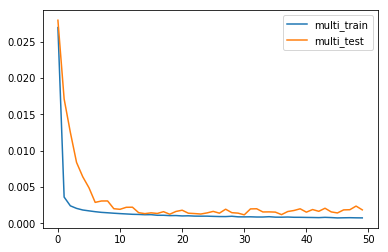

In [20]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [21]:
yhat = model.predict(test_X)

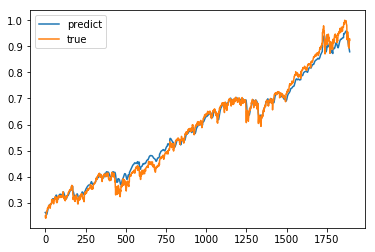

In [22]:
pyplot.plot(yhat[:,0], label='predict')
pyplot.plot(test_y[:,0], label='true')
pyplot.legend()
pyplot.show()

In [23]:
test_X.shape

(1892, 10, 8)

In [24]:
test_X.shape

(1892, 10, 8)

In [25]:
#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-8:]

In [27]:
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y[:,-8:].shape
inv_y = inv_y[:,-8:]

In [28]:
rmse = sqrt(mean_squared_error(test_y[:,0], yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.020


In [29]:
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 53.689


In [30]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y[:,0], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,0], name= 'Multi Predict Price')
py.iplot([multi_predict_chart, actual_chart])